In [1]:
# Importing libraries # 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from nltk.corpus import stopwords 
STOPWORDS = set(stopwords.words('english'))
%matplotlib inline


from torchnlp.encoders.text import  pad_tensor
from sklearn.model_selection import train_test_split



In [2]:
# Read dataset 
df = pd.read_feather('SentimenAnalysis.ftr')
df.head()

,labels,text
0,positive,i have bought several of the vitality canned d...
1,negative,product arrived labeled as jumbo salted peanut...
2,negative,this is a confection that has been around a fe...
3,negative,if you are looking for the secret ingredient i...
4,positive,great taffy at a great price there was a wide ...


In [3]:
# Cleaning the dataset
import re 
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", ' ', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in STOPWORDS])

df['text'] = [preprocess_string(text) for text in df['text'].values]
# df['text'] = [remove_stopwords(text) for text in df['text'].values]


In [4]:
# get encoded representation 
# Simple word to id mapping 
from torchnlp.encoders.text import StaticTokenizerEncoder, pad_tensor

text_list = df['text'].values
encoder = StaticTokenizerEncoder(text_list, tokenize=lambda s: s.split())
encoded_data = [encoder.encode(example) for example in text_list]


Max length : 156.0 


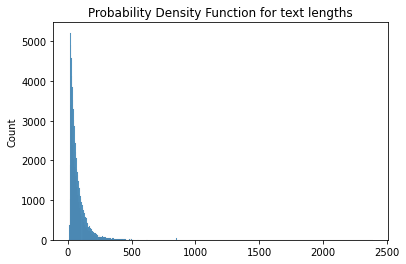

In [5]:
# find max length of dataset 
lengths = [len(i) for i in encoded_data]
length_as_series = pd.Series(lengths)
plt.title("Probability Density Function for text lengths")
sns.histplot(length_as_series)

max_pad_length = length_as_series.quantile(0.9)
print(f'Max length : {max_pad_length} ')

In [6]:
# discard the long inputs 
reviews = []
ylabel = []
for i in range(len(encoded_data)):
    if len(encoded_data[i]) < max_pad_length:
        reviews.append(encoded_data[i])
        ylabel.append(df['labels'][i])

from sklearn.preprocessing import LabelEncoder
# encode the labels 
lb = LabelEncoder()
labels = lb.fit_transform(ylabel)
        

# pad the dataset 
padded_dataset = []
for i in tqdm(range(len(reviews)), desc="Padding the dataset : "):
    padded_dataset.append(pad_tensor(reviews[i], int(max_pad_length)))


Padding the dataset :   0%|          | 0/89983 [00:00<?, ?it/s]

In [7]:
#preparing the final dataset:
X = torch.stack(padded_dataset)
y = torch.tensor(labels)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.25,
                                                    random_state=42)


X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)


C:\Users\RJNGh\AppData\Local\Temp\ipykernel_13608\2972527356.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, y_train = torch.tensor(X_train), torch.tensor(y_train)
C:\Users\RJNGh\AppData\Local\Temp\ipykernel_13608\2972527356.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test, y_test = torch.tensor(X_test), torch.tensor(y_test)


In [8]:
from lstm import CustomLSTM

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(len(encoder.vocab)+1, 32)
        self.lstm = CustomLSTM(32,32)#nn.LSTM(32, 32, batch_first=True)

        self.fc1 = nn.Linear(32, 2)
        
    def forward(self, x):
        x_ = self.embedding(x)
        x_, (h_n, c_n) = self.lstm(x_)
        x_ = (x_[:, -1, :])
        x_ = self.fc1(x_)
        return x_

In [10]:
ds_train = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(ds_train, batch_size=128, shuffle=True)

ds_test = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(ds_test, batch_size=256, shuffle=True)

In [11]:
CUDA  = torch.cuda.is_available()
classifier = Net()
if CUDA:
    classifier = classifier.cuda()

optimizer = optim.Adam(classifier.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

In [12]:

epohcs = 5
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []


epoch_bar = tqdm(
    range(epohcs))
for epoch in epoch_bar:

    #################################################################### Training ######################################
    correct = 0
    iterations = 0 
    iter_loss = 0.0 

    batch_bar  = tqdm(
    enumerate(train_loader),
    desc="Epoch: {}/{}".format(str(epoch + 1),str(epohcs)),
    total=len(train_loader))

    for i , (datapoints, labels) in batch_bar:
        if CUDA:
            datapoints = datapoints.cuda()
            labels     = labels.cuda()

        # Forward prop
        preds = classifier(datapoints)
        loss = criterion(preds, labels)
        iter_loss += loss.item()

        # Backprop 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _ , predicted = torch.max(preds , 1 )
        correct += (predicted == labels).sum().item()
        iterations += 1

        batch_bar.set_postfix(loss=iter_loss / iterations,
                        accuracy="{:.2f}".format(correct / len(X_train)))
        batch_bar.update()
         

    train_accuracy.append(100 * correct / len(X_train))
    train_loss.append(iter_loss / iterations)
    ########################################### Testing ###################################################
    iter_loss = 0.0 
    correct = 0
    iterations = 0 

    classifier.eval() 

    for i , (inputs, labels) in enumerate(test_loader):

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs =  classifier(inputs)
        loss = criterion(outputs, labels)
        iter_loss += loss.item()
        _ , predicted = torch.max(outputs , 1 )
        correct += (predicted == labels).sum().item()
        iterations += 1 
    
    test_loss.append(iter_loss/ iterations)
    test_accuracy.append(100 * correct / len(X_test))




    epoch_bar.set_postfix( Training_loss=train_loss[-1],
                        Training_accuracy="{:.2f}".format(train_accuracy[-1]) , Testing_loss = test_loss[-1], Test_accuracy ="{:.2f}".format(test_accuracy[-1]) )
    epoch_bar.update()


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5:   0%|          | 0/528 [00:00<?, ?it/s]

Epoch: 2/5:   0%|          | 0/528 [00:00<?, ?it/s]

Epoch: 3/5:   0%|          | 0/528 [00:00<?, ?it/s]

Epoch: 4/5:   0%|          | 0/528 [00:00<?, ?it/s]

Epoch: 5/5:   0%|          | 0/528 [00:00<?, ?it/s]

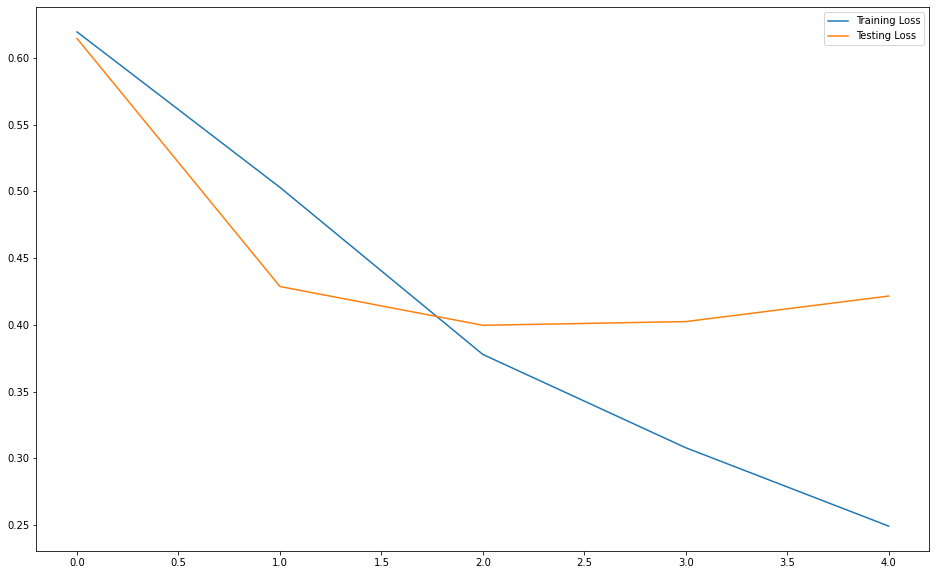

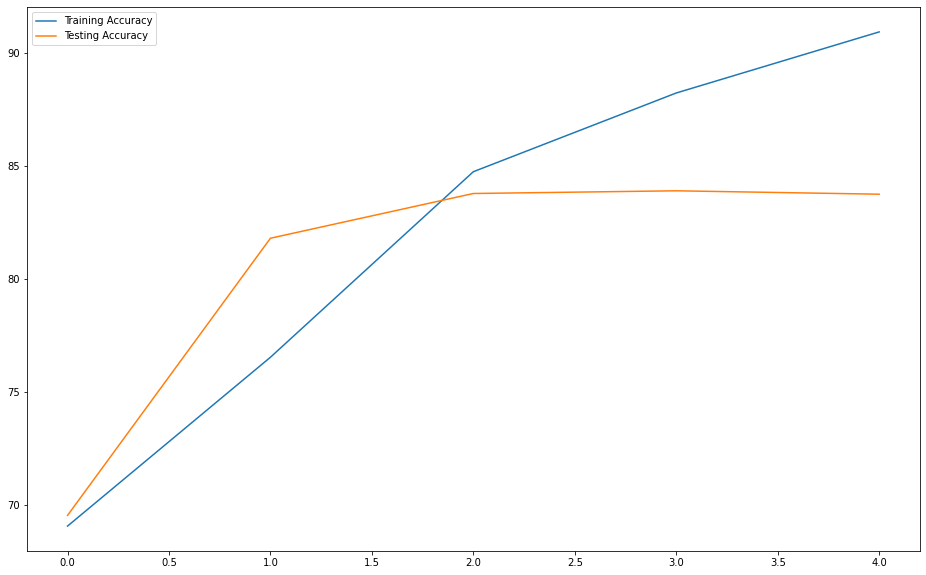

In [15]:
# Loss
import matplotlib.pyplot as plt 
f = plt.figure(figsize=(16, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

# Accuracy
f = plt.figure(figsize=(16, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()